In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import keras
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import warnings

# ignorar warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [30]:
#leitura das cotações
base = pd.read_csv('ABEV3.SA.csv')

In [31]:
base.isnull().sum()

Date          0
Open         13
High         13
Low          13
Close        13
Adj Close    13
Volume       13
dtype: int64

In [32]:
#remove os dados 'NULL'
base.dropna(inplace=True)
#base_treinamento recebe apenas os valores de Abertura
base_treinamento = base.iloc[:,1:2].values
base = base['Open']

In [33]:
#os dados serão normalizados para melhorar a performance e dimensionalidade (escala entre 0 e 1)
from sklearn.preprocessing import MinMaxScaler
min_scaler = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizado = min_scaler.fit_transform(base_treinamento)
base_treinamento_normalizado[0:5]

array([[0.11620283],
       [0.11767347],
       [0.11664545],
       [0.11767347],
       [0.11782205]])

In [34]:
#Utilizaremos uma janela de 500 dias anteriores da base de treinamento para nossas previsões.
previsores = []
preco_real = []

for i in range(500, len(base)):
    previsores.append(base_treinamento_normalizado[i-500:i,0])
    preco_real.append(base_treinamento_normalizado[i,0])
    

In [35]:
print('Tamanho do Dataset criado de previsores', len(previsores))
print('Tamanho do Dataset criado de preco_real', len(preco_real))

Tamanho do Dataset criado de previsores 3356
Tamanho do Dataset criado de preco_real 3356


In [36]:
#Os dados serão transformados para o formato do Numpy
previsores, preco_real = np.array(previsores), np.array(preco_real)
print('Formato Previsores', previsores.shape)
print('Formato Preco_real', preco_real.shape)

Formato Previsores (3356, 500)
Formato Preco_real (3356,)


In [37]:
#Converter o formato para o padrão Keras
previsores = np.reshape(previsores, newshape = (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(3356, 500, 1)

In [38]:
#Criação do regressor com Rede Neural Recorrente
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))

regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1, activation='linear'))

In [39]:
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [40]:
#Treinamento da Rede Neural
regressor.fit(previsores, preco_real, epochs=2, batch_size=32)

Epoch 1/2
105/105 [==============================] - 78s 739ms/step - loss: 0.0174 - mean_absolute_error: 0.0851
Epoch 2/2
105/105 [==============================] - 77s 734ms/step - loss: 0.0054 - mean_absolute_error: 0.0520


In [42]:
previsoes_teste = pd.DataFrame(columns=['teste'])
for i in range(0, 23):
    X_teste = []
    entradas = base[len(base) - 3500:].values
    entradas = entradas.reshape(-1,1)
    entradas = min_scaler.transform(entradas)
    
    X_teste.append(entradas[0:,0])
    X_teste = np.array(X_teste)
    X_teste = np.reshape(X_teste, newshape=(X_teste.shape[0], X_teste.shape[1], 1))
    
    previsoes = regressor.predict(X_teste)
    previsoes = min_scaler.inverse_transform(previsoes)  

    previsoes_teste.loc[i] = previsoes[0][0]
    previsoes_teste
    
    previsoes = pd.DataFrame(np.array(previsoes).T)
    
    
    base = base.append(previsoes, ignore_index = True)

In [43]:
previsoes_teste = previsoes_teste.iloc[:,0:].values
previsoes_teste = np.round(previsoes_teste, 2)
previsoes_teste

array([[17.21],
       [17.3 ],
       [17.39],
       [17.48],
       [17.57],
       [17.66],
       [17.75],
       [17.84],
       [17.92],
       [18.01],
       [18.1 ],
       [18.19],
       [18.27],
       [18.36],
       [18.45],
       [18.54],
       [18.62],
       [18.71],
       [18.79],
       [18.88],
       [18.97],
       [19.05],
       [19.14]], dtype=float32)

In [44]:
base_teste = pd.read_csv('ABEV3.SA_teste.csv')
base_teste.isnull().sum().max()
base_completa = pd.concat((base, base_teste['Open']), axis=0)
base_completa.isnull().sum().max()
base_completa.dropna(inplace=True)
preco_real_teste = base_teste.iloc[:,1:2].values
preco_real_teste

array([[14.49],
       [14.93],
       [15.19],
       [15.16],
       [15.8 ],
       [14.81],
       [13.94],
       [13.68],
       [13.6 ],
       [13.23],
       [13.19],
       [13.38],
       [13.38],
       [13.53],
       [13.55],
       [13.24],
       [13.21],
       [13.02],
       [13.08],
       [12.67],
       [12.86],
       [13.06],
       [12.89]])

In [45]:
quadro_previsao = np.concatenate((preco_real_teste, previsoes_teste), axis= 1)

In [47]:
quadro_previsao = pd.DataFrame(quadro_previsao, columns=['Preco_real', 'Previsao'])
quadro_previsao['Erro'] = quadro_previsao['Preco_real'] - quadro_previsao['Previsao']
quadro_previsao['Erro'] = np.round(quadro_previsao['Erro'], 2)
quadro_previsao['Previsao'] = np.round(quadro_previsao['Previsao'], 2)
quadro_previsao

,Preco_real,Previsao,Erro
0,14.49,17.21,-2.72
1,14.93,17.30,-2.37
2,15.19,17.39,-2.20
3,15.16,17.48,-2.32
4,15.80,17.57,-1.77
5,14.81,17.66,-2.85
6,13.94,17.75,-3.81
7,13.68,17.84,-4.16
8,13.60,17.92,-4.32
9,13.23,18.01,-4.78


In [48]:
print('Media Preco Reais', preco_real_teste.mean())
print('Media Previsoes', previsoes_teste.mean())
print('Diferenca da media entre o valor_real e a previsao', round(previsoes_teste.mean() - preco_real_teste.mean(), 2))

Media Preco Reais 13.734347826086958
Media Previsoes 18.182606
Diferenca da media entre o valor_real e a previsao 4.45


<function matplotlib.pyplot.show(*args, **kw)>

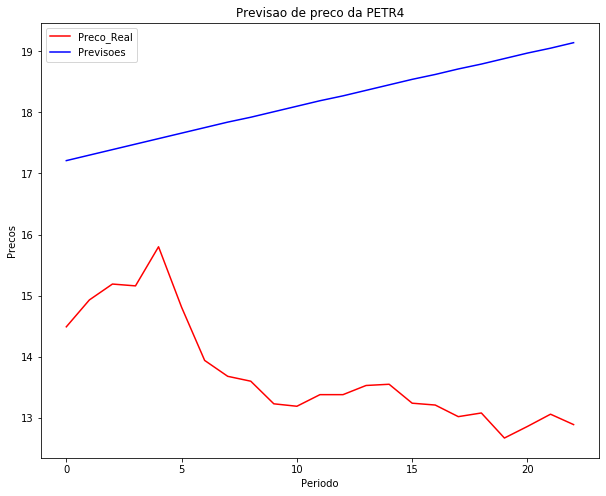

In [49]:
plt.figure(figsize=(10,8))
plt.plot(preco_real_teste, color='red', label='Preco_Real')
plt.plot(previsoes_teste, color = 'blue', label = 'Previsoes')
plt.title('Previsao de preco da PETR4')
plt.legend()
plt.xlabel('Periodo')
plt.ylabel('Precos')
plt.show